# 对比实验

## 1 Baseline

### 1.1 导包

In [50]:
import time
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



# import logging

# # 创建一个logger
# logger = logging.getLogger(__name__)

# # 设置日志级别为INFO
# logger.setLevel(logging.INFO)

# # 创建一个控制台输出的Handler
# handler = logging.StreamHandler()
# logger.addHandler(handler)


### 1.2 导入模型

In [51]:
## 定义ResNet18分类器
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # 加载预训练的ResNet18模型
        self.resnet = models.resnet18(pretrained=True)
        
        # 替换最后一层全连接层
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

num_classes = 10  # 假设有10个分类
model = ResNetClassifier(num_classes)
    
net = ResNetClassifier(10)
input_tensor = torch.randn(64, 3, 32, 32)       #  TODO: 切换成输入分类数据的维度
output_tensor = net(input_tensor)

output_tensor.shape

/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 10])

### 1.3 定义训练过程

In [52]:
def train_and_evaluate(model, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    criterion = nn.BCEWithLogitsLoss()  # 使用二元交叉熵损失函数
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        model.train()
        start_time = time.time()
        model.to(device)
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            labels = F.one_hot((labels), num_classes=num_epochs).float()
            
            outputs = model(inputs).squeeze()  # 去掉额外的维度
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()
        train_mean_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_mean_loss)

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = F.one_hot((labels), num_classes=num_classes).float()
            outputs = model(inputs).squeeze()
            outputs = torch.argmax(outputs, dim=1)
            outputs = F.one_hot(outputs, num_classes=num_classes).float()
            val_loss = criterion(outputs, labels)
            epoch_val_loss += val_loss.item()
        val_mean_loss = epoch_val_loss / len(train_loader)

        scheduler.step(val_mean_loss)
        val_losses.append(val_mean_loss)

        end_time = time.time()
        total_time = end_time - start_time
        current_lr = optimizer.param_groups[0]['lr']
        print(f'👉optim:{optimizer.__class__.__name__} + sched:{scheduler.__class__.__name__} - [Epoch {epoch+1}/{num_epochs}], \
              Train Loss: {train_mean_loss:.4f}, Val Loss: {val_mean_loss:.4f}, Time: {total_time:.2f}, LR: {current_lr:.6f}')
    return train_losses, val_losses

# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
# val_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # train_dataset[0][0].shape

# def get_optimizers(model, lr, name):
#     optimizers = {
#         'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5),
#         'Adam': optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999)),
#         'RMSprop': optim.RMSprop(model.parameters(), lr=lr, alpha=0.9),
#         'AdamW': optim.Adamax(model.parameters(), lr=lr, weight_decay=1e-5),
#         'ASGD': optim.ASGD(model.parameters(), lr=lr, lambd=0.0001)
#     }  

#     return optimizers[name]

# def get_schedulers(optimizer, name):
#     schedulers = {
#         'constant': optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0),
#         'step': optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),
#         'exp': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
#         'cos': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200),
#         'reduce': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
#         # 'warmup': optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 10)
#     }
#     return schedulers[name]


# num_classes = 10  # CIFAR-10有10个类别
# lr = 0.01
# model = ResNetClassifier(num_classes)

# optim_name = 'SGD'
# scheduler_name = 'step'

# optimizer = get_optimizers(model, lr, optim_name)

# scheduler = get_schedulers(optimizer, scheduler_name)

# # 运行实验
# train_results = {}
# val_results = {}
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# name = f'{optim_name}_{scheduler_name}'

# train_results[name], val_results[name] = train_and_evaluate(model, optim_name, scheduler_name, optimizer, scheduler, train_loader, val_loader, device)


### 1.4 定义优化器

In [53]:
def get_optimizers(model, lr, name):
    optimizers = {
        'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5),
        'Adam': optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999)),
        'RMSprop': optim.RMSprop(model.parameters(), lr=lr, alpha=0.9),
        'AdamW': optim.Adamax(model.parameters(), lr=lr, weight_decay=1e-5),
        'ASGD': optim.ASGD(model.parameters(), lr=lr, lambd=0.0001)
    }  

    return optimizers[name]

### 1.5 定义调度器

In [54]:
def get_schedulers(optimizer, name):
    schedulers = {
        'constant': optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0),
        'step': optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01),
        'exp': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
        'cos': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200),
        'reduce': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
        # 'warmup': optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 10)
    }
    return schedulers[name]

### 1.6 读取数据

In [55]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataset[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])

## 2. 对比实验

### 2.1. 优化器效果对比实验

In [56]:
def plot_results(results, title_txt, save_path):
    plt.figure(figsize=(8, 5))
    for name, losses in results.items():
        plt.plot(losses, label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title_txt)
    plt.legend()
    plt.savefig(save_path)
    plt.show()
    print(f'img saved: {save_path}')

In [57]:
import os

def run_experiments(num_classes, optims_list, scheds_list, lr, num_epochs, device, svae_path_root):
    """Run a set of experiments and plot the results."""
    train_dict = {}
    val_dict = {}
    for optim_name in optims_list:
        trian_results = {}
        val_results = {}
        for sched_name in scheds_list:
            print(f'Running experiment: {optim_name}, {sched_name}')
            model = ResNetClassifier(num_classes)                           # 每次都要初始化
            optimizer = get_optimizers(model, lr, optim_name)
            scheduler = get_schedulers(optimizer, sched_name)
            name = f'{optimizer.__class__.__name__}_{scheduler.__class__.__name__}'
            trian_results[name], val_results[name] = train_and_evaluate(model, optimizer, scheduler, train_loader, val_loader, num_epochs, device)
        plot_results(trian_results, f'Train Results Compare on {name}', save_path=os.path.join(svae_path_root, f'train_{optim_name}.jpg'))
        plot_results(val_results, f'Val Results Compare on {name}', save_path=os.path.join(svae_path_root, f'val_{optim_name}.jpg'))
        train_dict.update(trian_results)
        val_dict.update(val_results)
    plot_results(train_dict, 'Train Results Compare', save_path=os.path.join(svae_path_root, f'train_all.jpg'))
    plot_results(val_dict, 'Val Results Compare', save_path=os.path.join(svae_path_root, f'val_all.jpg'))
    print('Finished!')
    print(train_dict,val_dict)

In [58]:

optims_list = ['SGD', 'Adam', 'RMSprop', 'AdamW', 'ASGD']
scheds_list = ['constant', 'step', 'exp', 'cos', 'reduce']

epochs = 10
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_save_path = './assert/优化器'


Running experiment: SGD, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


👉optim:SGD + sched:StepLR - [Epoch 1/10],               Train Loss: 0.1650, Val Loss: 0.1367, Time: 10.37, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1026, Val Loss: 0.1360, Time: 10.36, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 3/10],               Train Loss: 0.0800, Val Loss: 0.1357, Time: 10.26, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 4/10],               Train Loss: 0.0630, Val Loss: 0.1355, Time: 9.98, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 5/10],               Train Loss: 0.0503, Val Loss: 0.1355, Time: 9.57, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 6/10],               Train Loss: 0.0404, Val Loss: 0.1354, Time: 10.21, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 7/10],               Train Loss: 0.0326, Val Loss: 0.1355, Time: 9.98, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 8/10],               Train Loss: 0.0270, Val Loss: 0.1356, Time: 10.44, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 9/10],  

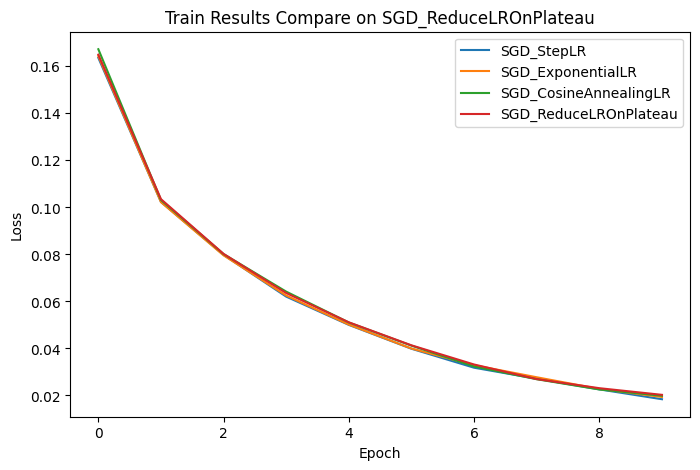

img saved: ./assert/优化器/train_SGD.jpg


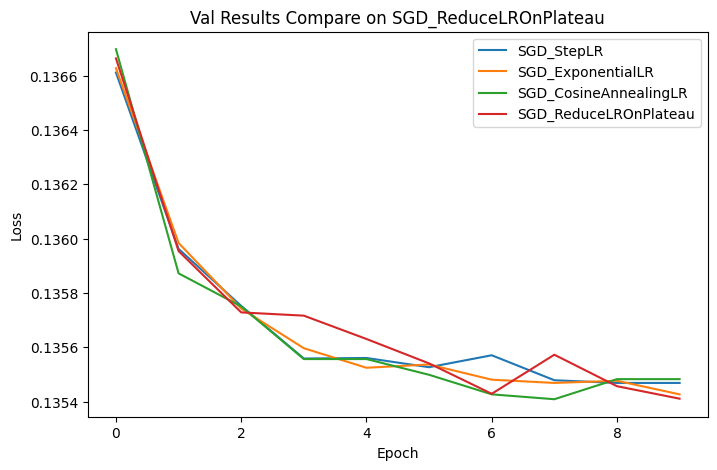

img saved: ./assert/优化器/val_SGD.jpg
Running experiment: Adam, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:Adam + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2891, Val Loss: 0.1421, Time: 11.24, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 2/10],               Train Loss: 0.2043, Val Loss: 0.1398, Time: 11.49, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1673, Val Loss: 0.1385, Time: 11.64, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1462, Val Loss: 0.1378, Time: 11.26, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1300, Val Loss: 0.1375, Time: 11.24, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1176, Val Loss: 0.1371, Time: 11.00, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1073, Val Loss: 0.1368, Time: 11.25, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 8/10],               Train Loss: 0.0975, Val Loss: 0.1370, Time: 10.99, LR: 0.010000
👉optim:Adam + sched:StepLR - [Ep

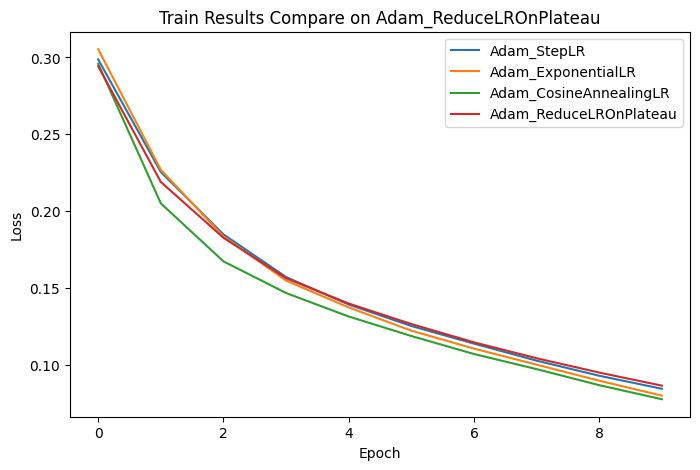

img saved: ./assert/优化器/train_Adam.jpg


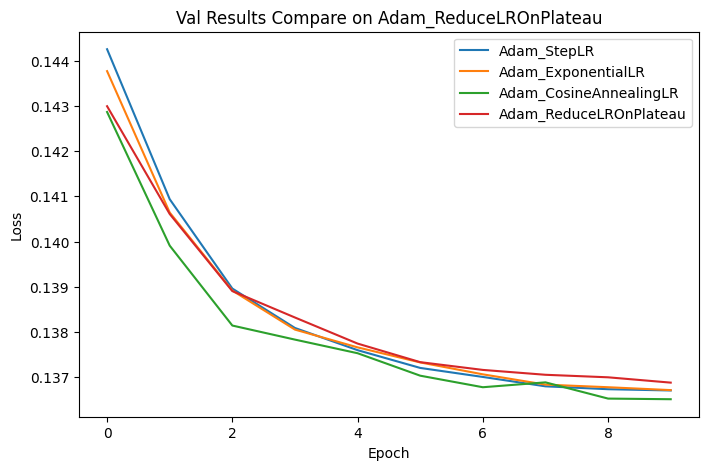

img saved: ./assert/优化器/val_Adam.jpg
Running experiment: RMSprop, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:RMSprop + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2986, Val Loss: 0.1449, Time: 10.09, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 2/10],               Train Loss: 0.2039, Val Loss: 0.1404, Time: 9.83, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1677, Val Loss: 0.1393, Time: 9.89, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1516, Val Loss: 0.1392, Time: 9.78, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1381, Val Loss: 0.1376, Time: 9.85, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1277, Val Loss: 0.1382, Time: 10.01, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1191, Val Loss: 0.1379, Time: 10.08, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 8/10],               Train Loss: 0.1119, Val Loss: 0.1369, Time: 10.13, LR: 0.010000
👉optim:RMSpr

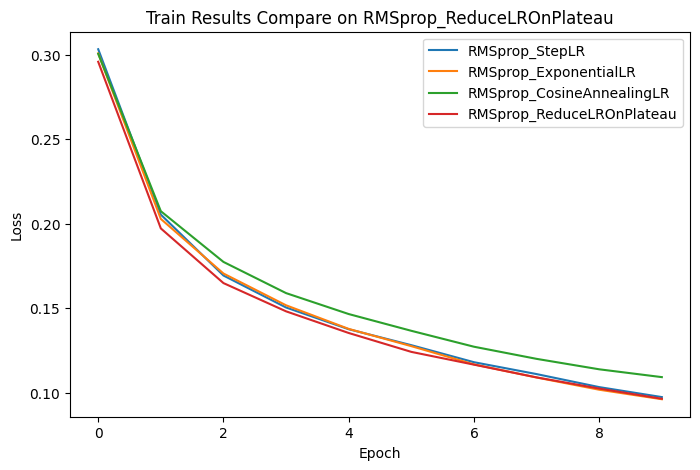

img saved: ./assert/优化器/train_RMSprop.jpg


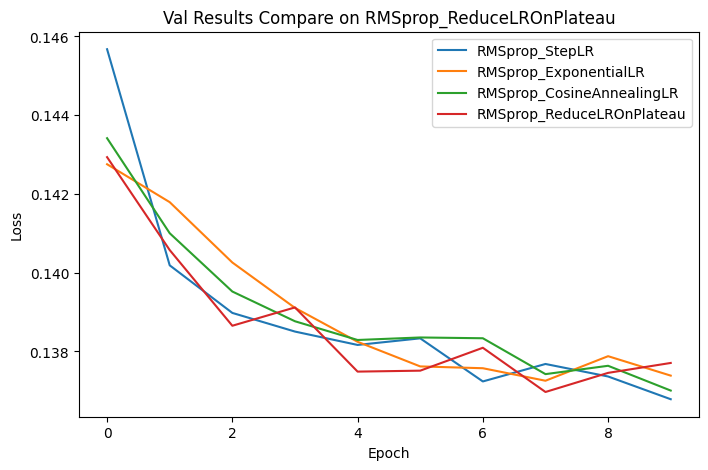

img saved: ./assert/优化器/val_RMSprop.jpg
Running experiment: AdamW, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:Adamax + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2668, Val Loss: 0.1413, Time: 11.09, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1776, Val Loss: 0.1387, Time: 11.03, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1452, Val Loss: 0.1375, Time: 11.55, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1226, Val Loss: 0.1371, Time: 11.77, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1119, Val Loss: 0.1367, Time: 11.76, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1026, Val Loss: 0.1368, Time: 11.37, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 7/10],               Train Loss: 0.0924, Val Loss: 0.1364, Time: 11.37, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 8/10],               Train Loss: 0.0834, Val Loss: 0.1363, Time: 11.28, LR: 0.010000
👉optim:Adamax + 

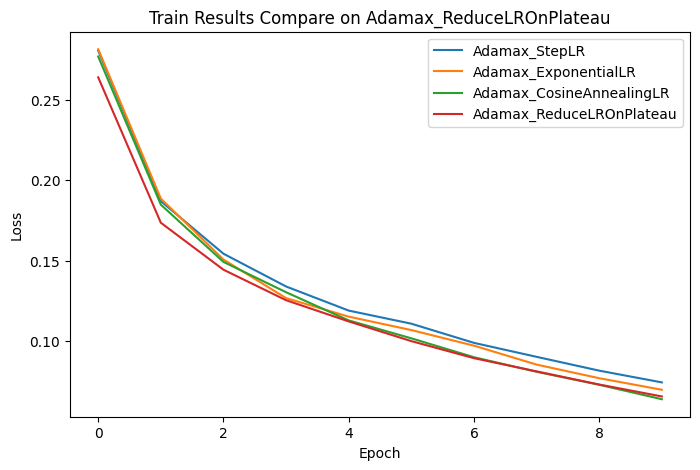

img saved: ./assert/优化器/train_AdamW.jpg


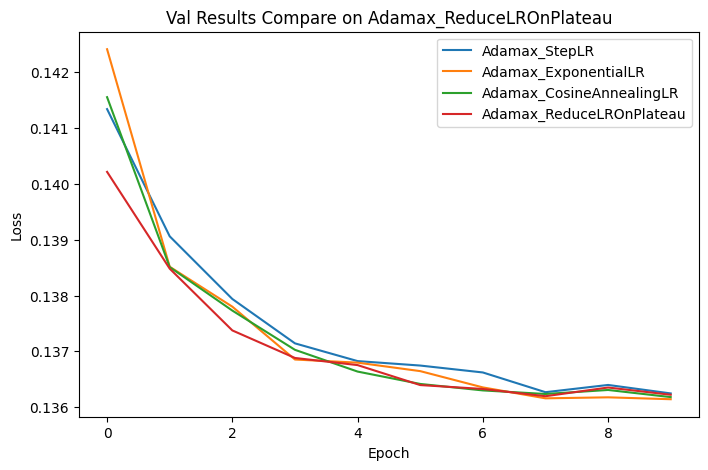

img saved: ./assert/优化器/val_AdamW.jpg
Running experiment: ASGD, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:ASGD + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2534, Val Loss: 0.1402, Time: 14.78, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1792, Val Loss: 0.1386, Time: 15.13, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1528, Val Loss: 0.1379, Time: 15.03, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1375, Val Loss: 0.1375, Time: 14.74, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1259, Val Loss: 0.1372, Time: 15.30, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1166, Val Loss: 0.1370, Time: 15.36, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1082, Val Loss: 0.1368, Time: 15.62, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 8/10],               Train Loss: 0.1017, Val Loss: 0.1366, Time: 15.32, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Ep

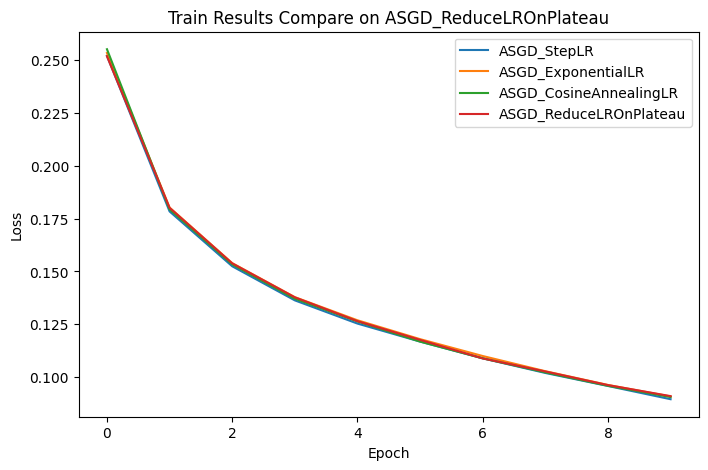

img saved: ./assert/优化器/train_ASGD.jpg


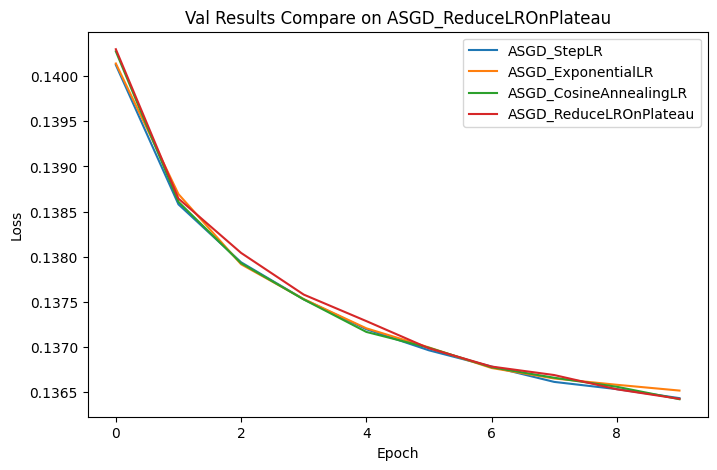

img saved: ./assert/优化器/val_ASGD.jpg
Finished!
{'ASGD_StepLR': [0.2518603323632494, 0.17835240698683902, 0.15243860993467634, 0.13632953028811517, 0.1253631440136591, 0.11685135724294521, 0.10894192090196073, 0.10203298070298894, 0.09588056826568625, 0.08962485430967015], 'ASGD_ExponentialLR': [0.25322246646789637, 0.1801881814932884, 0.15392488370770993, 0.13784825879975657, 0.12692134682555942, 0.11800926437844401, 0.1100425622175874, 0.10286305674716183, 0.09636783025339436, 0.090930811422484], 'ASGD_CosineAnnealingLR': [0.2549897755693902, 0.1793212526766083, 0.15332886662400896, 0.13709814354891667, 0.1263636616451661, 0.11685739355185605, 0.1089553407981725, 0.10230377325049751, 0.09597664142070371, 0.09063677010995805], 'ASGD_ReduceLROnPlateau': [0.2516630522697173, 0.18005476399417727, 0.1538159568767871, 0.13776717099654096, 0.1264983875786557, 0.11766818339181373, 0.1088986822816036, 0.10273869332316739, 0.09629659513321222, 0.09108188098101207]} {'ASGD_StepLR': [0.1401241586

In [59]:
# 开始实验
run_experiments(num_classes, optims_list, scheds_list, lr, epochs, device, img_save_path)